### Main file for calibration ###

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import function as f
from scipy.signal import find_peaks
from NewCalibration import Calib_position
from NewCalibration import Calib_energy
from NewCalibration import Calib_channel

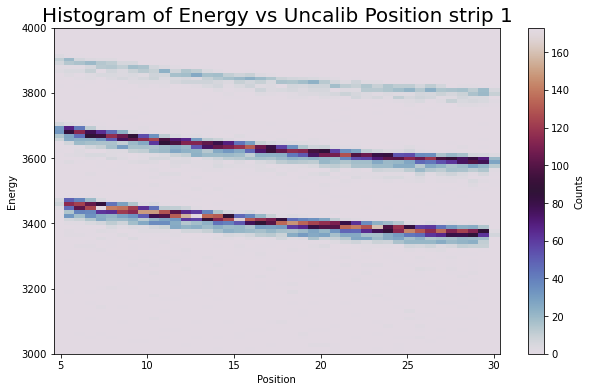

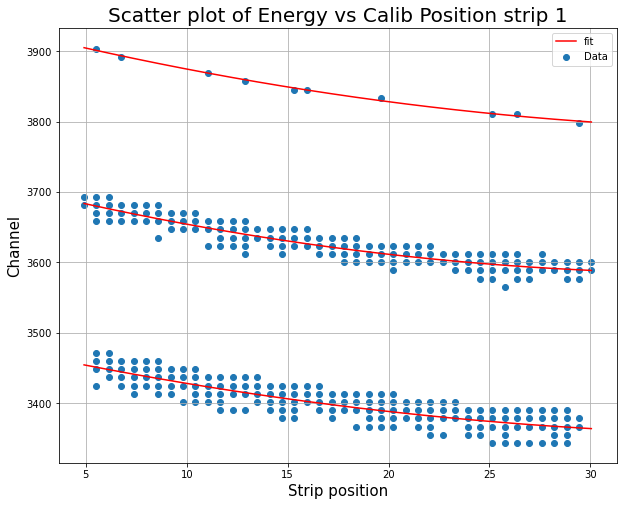

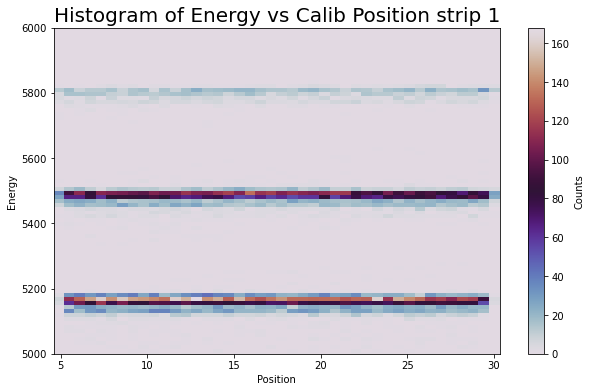

In [2]:

# this part handles the balistic calibration

lower_bound = [3500, 3500, 3500, 3500, 3500, 3450, 3450, 3400, 3500, 3500, 3500, 3500, 3550, 3500, 3450] # seen from plot_data
upper_bound = [3750, 3700, 3700, 3700, 3700, 3700, 3700, 3700, 3700, 3700, 3700, 3800, 3800, 3700, 3700]

# tabulated energies of the alpha particles

energy1 = 5156.59 
energy2 = 5485.46
energy3 = 5804.77


thres= [20, 20, 20, 20, 20, 15, 20, 15, 15, 30, 15, 15, 15, 10, 15, 20] # threshold for selecting relevant counts


for ii in range(1,2):
    file = "20240808_test001_0001_uncal.txt"
    strip = ii
    my_cal = Calib_position("Strippos", "Energy")
    my_cal.read_data(file)
    my_cal.plot_hist(strip)
    my_cal.plot_data(strip, thres[ii-1])
    my_cal.fit_data(strip, lower_bound[ii-1], upper_bound[ii-1]) 
    #my_cal.fit_results()
    #my_cal.write_txt('fit_results', strip, energy1, energy2, energy3)
    my_cal.plot_calib_hist(lower_bound[ii-1], upper_bound[ii-1], strip, energy1, energy2, energy3)

c0 = 12.881444863382615 +/- 4.154246560617632
c1 = 14645.156513139318 +/- 107.36347650564315
m1 = 5175.86165340166 +/- 0.10533502180655183
s1 = 12.448562749005214 +/- 0.10546234998672915
c2 = 12725.93250595281 +/- 115.4240192029523
m2 = 5397.653960572392 +/- 0.11273942197590028
s2 = 10.766900643821353 +/- 0.11282094467273227
c3 = 2128.5410192412573 +/- 113.11877680255333
m3 = 5609.7232140211845 +/- 0.6876599795415202
s3 = 11.201273151550595 +/- 0.6875573761000409


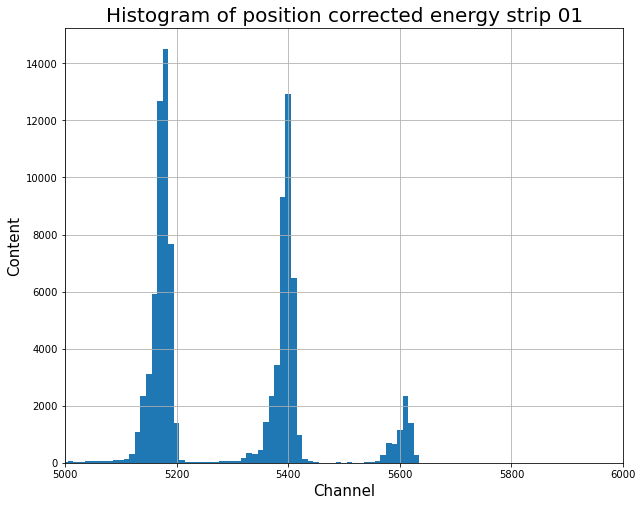

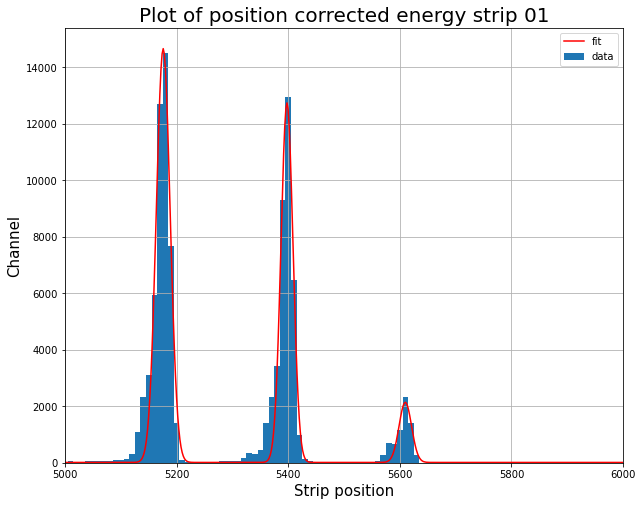

In [3]:
# This part performs the gaussian fit

for ii in range(1,2):
    if ii<10:
        file = '16 Strip Position Corrected Energy 0'+str(ii)+'.hdat'
        strip = '0'+str(ii)
    else:
        file = '16 Strip Position Corrected Energy '+str(ii)+'.hdat'
        strip = str(ii)
    my_en = Calib_energy("# X ", "Content")
    my_en.read_data(file)
    my_en.plot_hist(strip)
    my_en.initial_guess()
    my_en.fit_gauss(strip)
    #my_en.write_txt('gauss_results', strip)


m = 1.484244772257016 +/- 0.004397686966237385
q = -2525.7525248714946 +/- 23.2399950445209
m = 1.5125713811237453 +/- 0.004810166899457598
q = -2674.375711868037 +/- 25.296035262339736
m = 1.490484146250965 +/- 0.005064319293599811
q = -2557.8479627837883 +/- 26.66860432205314
m = 1.4851823063681897 +/- 0.00497942599726232
q = -2529.7355761886483 +/- 26.245004799474593
m = 1.4873087498918018 +/- 0.005607143099721663
q = -2538.632944494354 +/- 29.529077763551584
m = 1.5108755577404631 +/- 0.007074026581695426
q = -2656.128695807033 +/- 37.165414193648786
m = 1.5134154088521714 +/- 0.004756447027504734
q = -2677.022147349673 +/- 25.06801176703828
m = 1.50903302938381 +/- 0.004659659932809156
q = -2656.2366164760356 +/- 24.503741710342187
m = 1.493458132721166 +/- 0.005014458619486862
q = -2576.784819448776 +/- 26.437373660585983
m = 1.4973449782783064 +/- 0.004280193260393842
q = -2590.8287079459155 +/- 22.57986465197463
m = 1.504874868557909 +/- 0.00433539709339272
q = -2631.4980982856

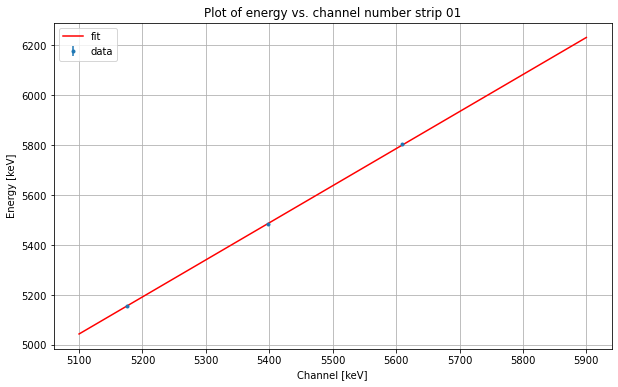

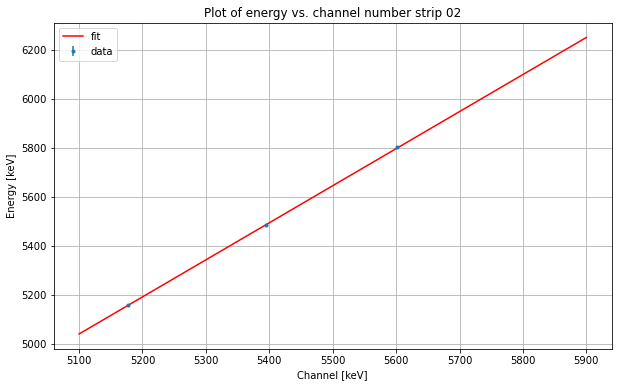

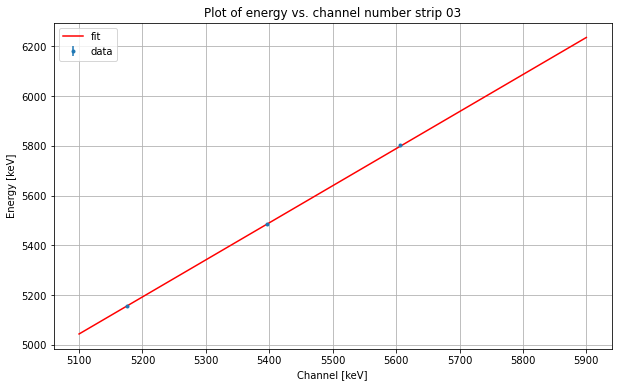

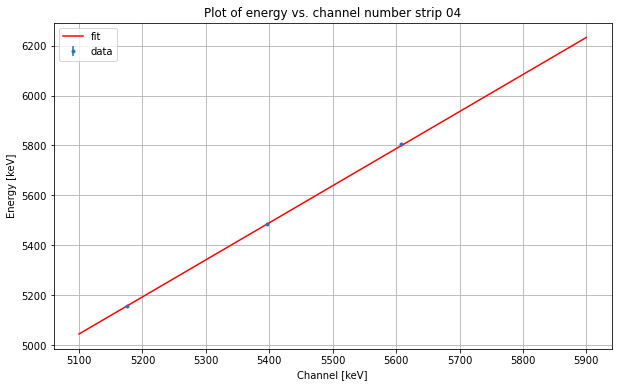

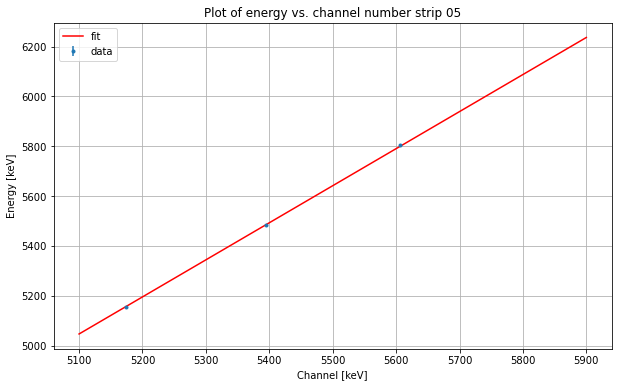

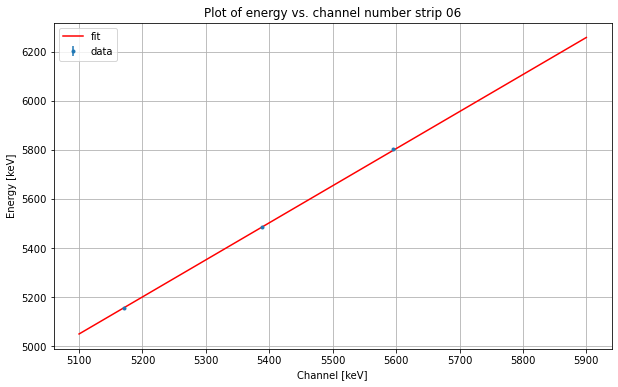

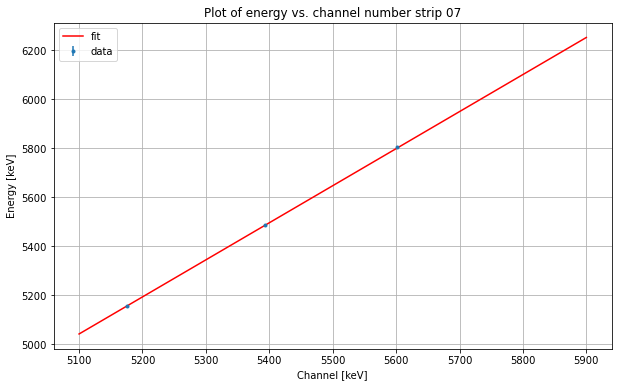

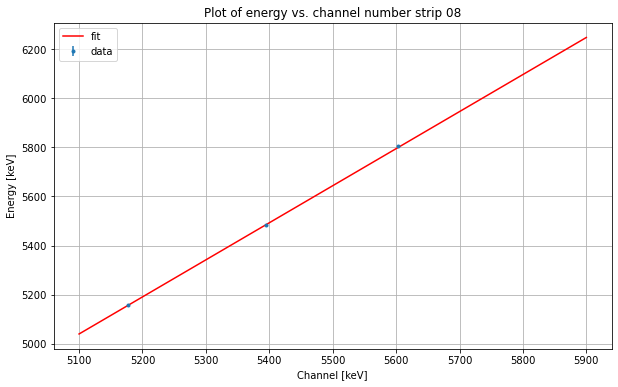

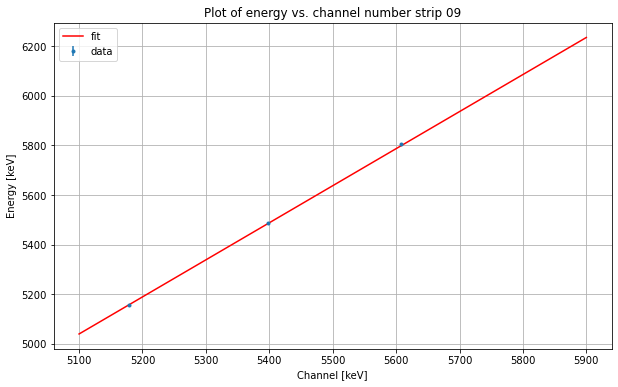

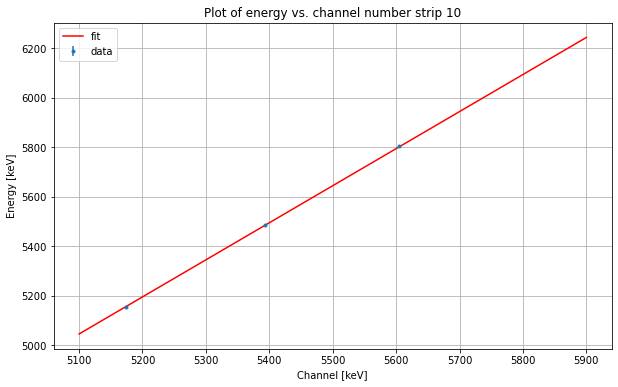

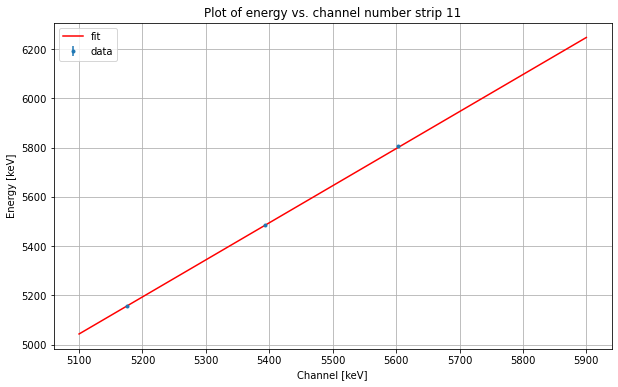

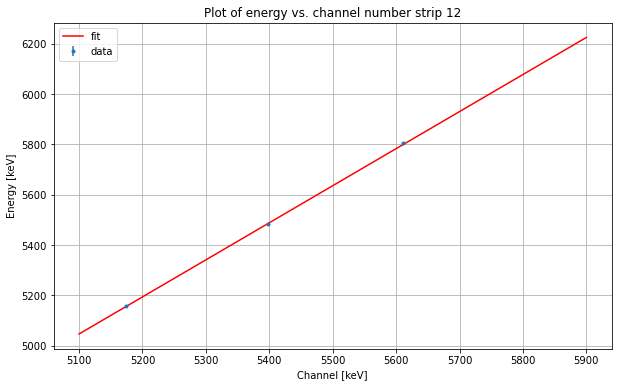

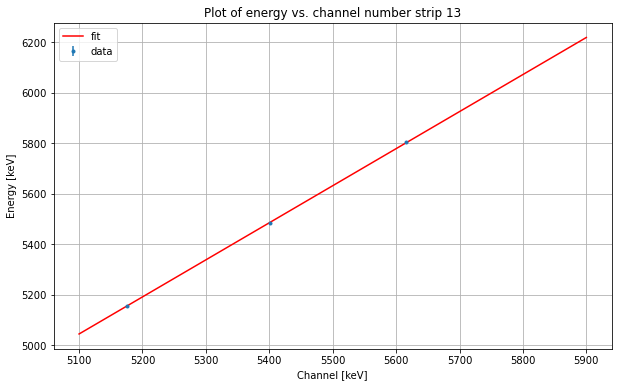

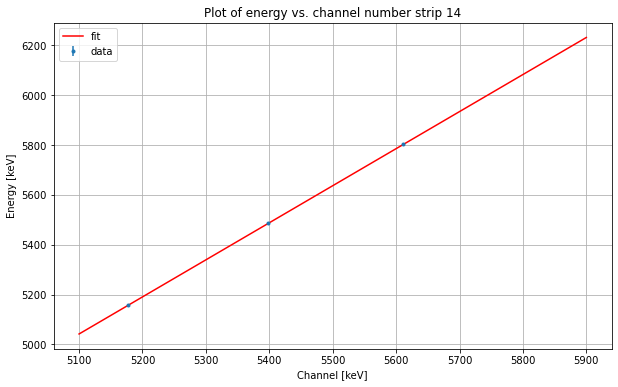

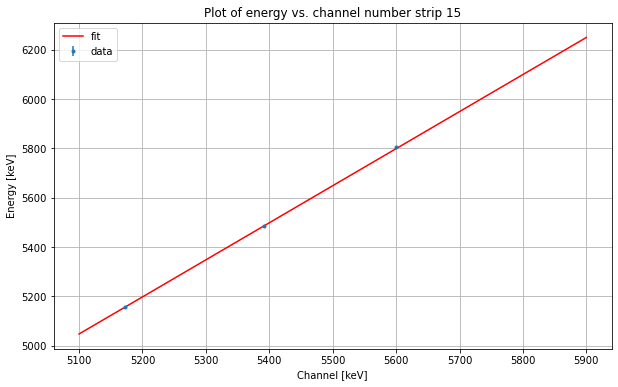

In [3]:
# This part handles the conversion between energy and channel

energy1 = 5156.59
energy2 = 5485.46
energy3 = 5804.77

for ii in range(1,16):
    if ii<10:
        file = 'gauss_results0'+str(ii)+'.dat'
        strip = '0'+str(ii)
    else:
        file = 'gauss_results'+str(ii)+'.dat'
        strip = str(ii)

    my_channel = Calib_channel(energy1, energy2, energy3)
    my_channel.read_txt(file)
    my_channel.fit_line(strip)
    my_channel.write_txt('line_results', strip)

In [6]:
# Writing in a text file the best fit parameters for each strip

work_dir = os.getcwd()
data_dir = os.path.join(work_dir, 'results')

m = []
q = []

path = os.path.join(work_dir, 'Calib_Energy_chiara.dat')
text=open(path, 'w')

for ii in range(1,16):
    if ii<10:
        filename = 'line_results0'+str(ii)+'.dat'
        strip = '0'+str(ii)
    else:
        filename = 'line_results'+str(ii)+'.dat'
        strip = str(ii)

    filepath = os.path.join(data_dir, filename)
    m_i, q_i = np.loadtxt(filepath, comments='#', unpack=True)
    print('%.3f %.3f' % (m_i, q_i), file=text)


text.close()


(4800.0, 6000.0)

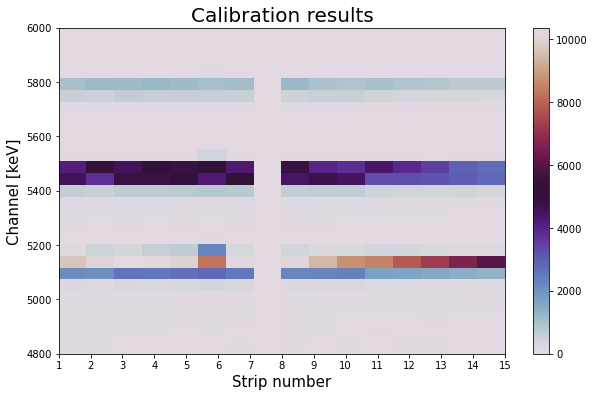

In [13]:

# Showing results of calibration

filename = "20240808_test001_0001_uncal.txt"
filepath = os.path.join(work_dir, filename)
my_df = pd.read_csv(filepath, sep=" ", header=0) 


position = my_df['Strippos'].to_numpy()
energy = my_df['Energy'].to_numpy()
strip = my_df['Stripnum'].to_numpy()



calib_position = "Calib_position_chiara.dat"
pos_path = os.path.join(work_dir, calib_position)
a,b,c = np.loadtxt(pos_path, unpack=True)

calib_energy = 'Calib_Energy_chiara.dat'
en_path = os.path.join(work_dir, calib_energy)
m,q = np.loadtxt(en_path, unpack=True)


corrected_energy=[]
corrected_strip=[]

for ii in range(1,16):
        index = my_df['Stripnum'].loc[my_df['Stripnum'] == ii].index
        strip_energy = energy[index]
        strip_position = position[index]
        strip_number = strip[index]
        energy_sel = strip_energy[strip_energy!=0] 
        position_sel = strip_position[strip_energy!=0]
        strip_sel = strip_number[strip_energy!=0]
        for jj in range(len(energy_sel)):

                delta_E = a[ii]*position_sel[jj]**2 + b[ii]*position_sel[jj] + c[ii]
                energy_corr = energy_sel[jj] - delta_E
                energy_fin = m[ii]*energy_corr + q[ii]
                corrected_energy.append(energy_fin)
                corrected_strip.append(ii)




plt.figure(figsize=(10,6))
plt.hist2d(corrected_strip, corrected_energy, bins=(16,500), cmap='twilight')
plt.colorbar()
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.xlabel('Strip number', fontsize=15)
plt.ylabel('Channel [keV]', fontsize=15)
plt.title('Calibration results', fontsize=20)
plt.ylim(4800,6000)